In [1]:
!pip install stellargraph

# LOAD DATASET 

In [2]:
import os 
import pandas as pd
from stellargraph import StellarGraph 

Mounted at /content/drive


In [ ]:
DATA_PATH=os.path.join(os.getcwd(),'DATA/')
SAVE_PATH=os.path.join(os.getcwd(),'saved_model/')
Result_PATH=os.path.join(os.getcwd(),'Result/')

In [3]:
edges_data=pd.read_csv(DATA_PATH+'sample.csv')
node_feature=pd.read_csv(DATA_PATH+'sample_feature.csv')
#node_feature=node_feature.drop_duplicates(subset=['index'])
node_features = node_feature.set_index(keys=['index'], inplace=False, drop=True)

In [4]:
node_features.head()

,1,2,3,4,5,6,7,8,9,10,...,290,291,292,293,294,295,296,297,298,299
index,,,,,,,,,,,,,,,,,,,,,
5887,-0.168308,0.453490,-0.095535,0.290504,-0.894610,0.103735,-0.280093,0.074014,0.503019,0.367744,...,-0.163552,-0.086980,-0.145552,0.070703,0.141626,0.001629,-0.096676,-0.052995,-0.112178,-0.090999
3426,2.397051,0.090396,1.236613,0.839081,0.093752,0.323479,-0.483196,-0.176435,-0.552185,0.748059,...,0.584843,0.119463,-0.409786,0.380476,-0.362136,0.192507,0.413073,-0.362811,-0.028254,0.358826
6340,0.844389,2.615271,0.093406,-1.072956,-0.955502,0.727380,-0.141938,-0.092633,0.751066,-1.077170,...,0.114912,-0.324140,-0.153945,0.141717,0.199205,-0.725853,-0.691025,0.233834,0.390434,-0.268641
7031,-0.560994,0.060390,-0.311671,0.110356,0.077707,0.342163,-0.432374,0.023661,0.243273,-0.051051,...,0.007316,0.084201,0.145957,0.006628,-0.108482,-0.102031,0.008283,-0.010563,0.212869,0.000766
7994,2.597059,3.824801,1.423339,1.348240,-2.891339,-0.556217,0.250086,-0.015109,1.021333,0.098333,...,-0.350584,-1.176642,1.377007,-1.279261,1.606988,-0.253019,0.147770,1.038439,0.548416,-1.134808


In [5]:
edges_data=edges_data.drop_duplicates()
edges_data.head()

,target,source
0,2,3
1,3,4
2,4,5
3,5,6
4,6,7


In [9]:
G_all = StellarGraph({"feature": node_features}, {"edge": edges_data})


In [7]:
print(G_all.info())

StellarGraph: Undirected multigraph
 Nodes: 8472, Edges: 267926

 Node types:
  feature: [8472]
    Features: float32 vector, length 299
    Edge types: feature-edge->feature

 Edge types:
    feature-edge->feature: [267926]
        Weights: all 1 (default)
        Features: none


# Extract Sub-GRAPH

In [ ]:
# sampleing from edge_list and align nodes

In [13]:
sub_edges=edges_data.sample(frac=0.1,replace=False,random_state=2211)

In [14]:
s=sub_edges['source'].tolist()
t=sub_edges['target'].tolist()
s.extend(t)
sub_nodes_idx=list(set(s))

In [15]:
sub_nodes=node_features.loc[sub_nodes_idx,:]

In [16]:
G_sub = StellarGraph({"feature": sub_nodes}, {"edge": sub_edges})

In [17]:
print(G_sub.info())

StellarGraph: Undirected multigraph
 Nodes: 5531, Edges: 26793

 Node types:
  feature: [5531]
    Features: float32 vector, length 299
    Edge types: feature-edge->feature

 Edge types:
    feature-edge->feature: [26793]
        Weights: all 1 (default)
        Features: none


In [18]:
non_sub_edges=edges_data.drop(sub_edges.index)

# Learn Sub-GRAPH 

In [19]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

sg.random.set_seed(1161)

In [21]:
nodes = list(G_sub.nodes())
number_of_walks = 40
length = 10

In [22]:
unsupervised_samples = UnsupervisedSampler(
    G_sub, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [23]:
batch_size = 64
epochs = 200

In [24]:
generator = Attri2VecLinkGenerator(G_sub, batch_size)

In [25]:
layer_sizes = [128]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

In [26]:
# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.in_out_tensors()

In [27]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [28]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-2),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=2,
    use_multiprocessing=True,
    workers=1,
    shuffle=True,
)

Epoch 1/200
62224/62224 - 212s - loss: 1.6559 - binary_accuracy: 0.5223 - 212s/epoch - 3ms/step
Epoch 2/200
62224/62224 - 208s - loss: 1.7394 - binary_accuracy: 0.5280 - 208s/epoch - 3ms/step
Epoch 3/200
62224/62224 - 207s - loss: 1.8010 - binary_accuracy: 0.5301 - 207s/epoch - 3ms/step
Epoch 4/200
62224/62224 - 206s - loss: 1.8447 - binary_accuracy: 0.5319 - 206s/epoch - 3ms/step
Epoch 5/200
62224/62224 - 206s - loss: 1.8819 - binary_accuracy: 0.5329 - 206s/epoch - 3ms/step
Epoch 6/200
62224/62224 - 207s - loss: 1.9004 - binary_accuracy: 0.5345 - 207s/epoch - 3ms/step
Epoch 7/200
62224/62224 - 204s - loss: 1.9093 - binary_accuracy: 0.5359 - 204s/epoch - 3ms/step
Epoch 8/200
62224/62224 - 205s - loss: 1.9150 - binary_accuracy: 0.5366 - 205s/epoch - 3ms/step
Epoch 9/200
62224/62224 - 206s - loss: 1.9392 - binary_accuracy: 0.5370 - 206s/epoch - 3ms/step
Epoch 10/200
62224/62224 - 204s - loss: 1.9505 - binary_accuracy: 0.5383 - 204s/epoch - 3ms/step
Epoch 11/200
62224/62224 - 205s - loss:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Netflix/at2v.model/assets


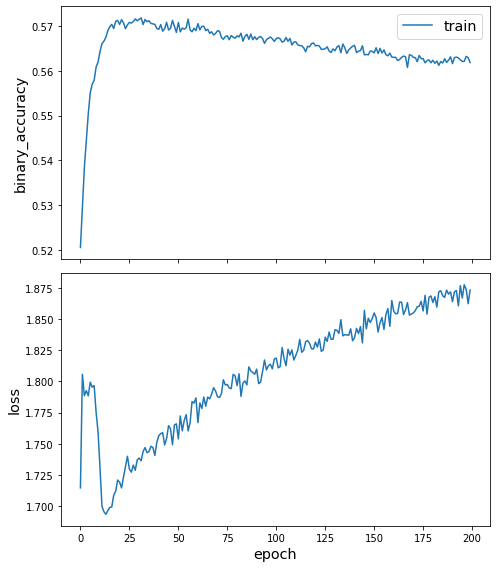

In [ ]:
model.save(SAVE_PATH+'at2v.model')
import matplotlib.pyplot as plt

fig=sg.utils.plot_history(history,return_figure=True)
fig.savefig(Result_PATH+'at2v')
sg.utils.plot_history(history)

# prediction

In [ ]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [ ]:
embedding_model.save(SAVE_PATH+'at2v_embedding.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Netflix/at2v_embedding.model/assets


In [ ]:
node_ids = node_features.index
node_gen = Attri2VecNodeGenerator(G_all, batch_size).flow(node_ids)
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

133/133 [==============================] - 0s 2ms/step


In [ ]:
edge_splitter_sub = EdgeSplitter(G_sub)
_, edge_ids_sub, edge_labels_sub = edge_splitter_sub.train_test_split(
    p=0.5, method="global", keep_connected=True
)

edge_labels_sub=edge_labels_sub.reshape(-1,1)
in_sample_edges=np.concatenate((edge_ids_sub, edge_labels_sub), axis=1)

** Sampled 40189 positive and 40189 negative edges. **


In [ ]:
edge_splitter_all = EdgeSplitter(G_all)
_, edge_ids_all, edge_labels_all = edge_splitter_all.train_test_split(
    p=0.5, method="global", keep_connected=True
)

edge_labels_all=edge_labels_all.reshape(-1,1)
out_of_sample_edges=np.concatenate((edge_ids_all, edge_labels_all), axis=1)

** Sampled 133963 positive and 133963 negative edges. **


In [ ]:
in_sample_edge_feat_from_emb = (
    node_embeddings[-1+in_sample_edges[:, 0]] 
    - node_embeddings[-1+in_sample_edges[:, 1]]
) ** 2
out_of_sample_edge_feat_from_emb = (
    node_embeddings[-1+out_of_sample_edges[:, 0]]
    - node_embeddings[-1+out_of_sample_edges[:, 1]]
) ** 2

In [ ]:
#logistic regression
clf_edge_pred_from_emb = LogisticRegression(
    verbose=0, solver="lbfgs", multi_class="auto", max_iter=500
)
clf_edge_pred_from_emb.fit(in_sample_edge_feat_from_emb, in_sample_edges[:, 2])

# logistic
edge_pred_from_emb = clf_edge_pred_from_emb.predict_proba(
    out_of_sample_edge_feat_from_emb
)

In [ ]:
# svm classfiieer 
clf_edge_pred_from_emb = SVC(
    kernel='linear',
    max_iter=1000,
    probability=True
)
clf_edge_pred_from_emb.fit(in_sample_edge_feat_from_emb, in_sample_edges[:, 2])



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(kernel='linear', max_iter=1000, probability=True)

In [ ]:
# svm
edge_pred_from_emb = clf_edge_pred_from_emb.predict_proba(
    out_of_sample_edge_feat_from_emb
)

In [ ]:
#save embedding 
with open('clf_at2v.pkl', 'wb') as f:
    pickle.dump(clf_edge_pred_from_emb,f)

clf_edge_pred_from_emb

SVC(kernel='linear', max_iter=1000, probability=True)

In [ ]:
if clf_edge_pred_from_emb.classes_[0] == 1:
    positive_class_index = 0
else:
    positive_class_index = 1

In [ ]:
auc=roc_auc_score(out_of_sample_edges[:, 2], edge_pred_from_emb[:, positive_class_index])
print('AUC : '+str(auc))

AUC : 0.5042857505644577


In [ ]:

pred=edge_pred_from_emb[:, positive_class_index]

prediction=[]
for i in range(len(pred)):
    if pred[i]>=0.5:
        answer=1
    else:
        answer=0
    prediction.append(answer)
prediction=np.array(prediction)
true=out_of_sample_edges[:, 2]

In [ ]:
accuracy_score(true, prediction)

0.4808715839448206